In [ ]:

# Analysis Plan:
# 1. Load the PDB structure (2VSM.pdb) using BioPython
# 2. Separate Chain A (NiV-G) and Chain B (ephrin-B2)
# 3. Calculate all inter-chain atomic distances
# 4. Identify Chain A residues with any atom within 4.5 Å of Chain B
# 5. Identify hydrogen bonds between chains (donor-acceptor distance < 3.5 Å, considering appropriate atoms)
# 6. Identify salt bridges between chains (charged residue pairs within 4.0 Å)
# 7. Generate comprehensive summary of interface residues and interactions

import warnings
warnings.filterwarnings('ignore')

from Bio.PDB import PDBParser, NeighborSearch, Selection
import numpy as np
import pandas as pd
from collections import defaultdict

# Load the PDB structure
parser = PDBParser(QUIET=True)
structure = parser.get_structure('2VSM', '2VSM.pdb')

print("Structure loaded successfully")
print(f"Structure ID: {structure.id}")

# Get the first model
model = structure[0]

# Display chains present
chains = list(model.get_chains())
print(f"\nChains present in structure: {[c.id for c in chains]}")

# Get Chain A (NiV-G) and Chain B (ephrin-B2)
chain_a = model['A']
chain_b = model['B']

print(f"\nChain A (NiV-G): {len(list(chain_a.get_residues()))} residues")
print(f"Chain B (ephrin-B2): {len(list(chain_b.get_residues()))} residues")


Structure loaded successfully
Structure ID: 2VSM

Chains present in structure: ['A', 'B']

Chain A (NiV-G): 917 residues
Chain B (ephrin-B2): 343 residues


In [ ]:

# Step 2: Identify interface residues in Chain A within 4.5 Å of Chain B
# Use NeighborSearch for efficient distance calculation

INTERFACE_DISTANCE_CUTOFF = 4.5  # Angstroms

# Get all atoms from both chains (excluding heteroatoms like water)
chain_a_atoms = [atom for atom in chain_a.get_atoms() if atom.get_parent().id[0] == ' ']
chain_b_atoms = [atom for atom in chain_b.get_atoms() if atom.get_parent().id[0] == ' ']

print(f"Chain A protein atoms: {len(chain_a_atoms)}")
print(f"Chain B protein atoms: {len(chain_b_atoms)}")

# Create NeighborSearch object with Chain B atoms
ns = NeighborSearch(chain_b_atoms)

# Find Chain A residues with atoms within cutoff distance of Chain B
interface_residues = set()
interface_contacts = []  # Store detailed contact information

for atom_a in chain_a_atoms:
    # Search for nearby atoms in Chain B
    nearby_atoms = ns.search(atom_a.coord, INTERFACE_DISTANCE_CUTOFF, level='A')
    
    if nearby_atoms:
        residue_a = atom_a.get_parent()
        interface_residues.add(residue_a)
        
        # Record the closest contact for this atom
        for atom_b in nearby_atoms:
            distance = np.linalg.norm(atom_a.coord - atom_b.coord)
            residue_b = atom_b.get_parent()
            
            interface_contacts.append({
                'chain_a_residue': residue_a.get_resname(),
                'chain_a_resid': residue_a.id[1],
                'chain_a_atom': atom_a.name,
                'chain_b_residue': residue_b.get_resname(),
                'chain_b_resid': residue_b.id[1],
                'chain_b_atom': atom_b.name,
                'distance': distance
            })

# Sort interface residues by residue number
interface_residues_sorted = sorted(list(interface_residues), key=lambda r: r.id[1])

print(f"\n=== INTERFACE RESIDUES (within {INTERFACE_DISTANCE_CUTOFF} Å) ===")
print(f"Total interface residues in Chain A: {len(interface_residues_sorted)}")
print("\nInterface residues:")
for res in interface_residues_sorted:
    print(f"  {res.get_resname()} {res.id[1]}")


Chain A protein atoms: 3269
Chain B protein atoms: 1104

=== INTERFACE RESIDUES (within 4.5 Å) ===
Total interface residues in Chain A: 33

Interface residues:
  SER 239
  CYS 240
  SER 241
  ARG 242
  LEU 305
  GLN 388
  TYR 389
  ILE 401
  ARG 402
  PHE 458
  PRO 488
  GLY 489
  GLN 490
  SER 491
  GLN 492
  GLU 501
  TRP 504
  GLU 505
  GLY 506
  VAL 507
  GLN 530
  THR 531
  ALA 532
  GLU 533
  ASP 555
  ASN 557
  ALA 558
  GLN 559
  GLU 579
  ILE 580
  TYR 581
  THR 583
  ILE 588


In [ ]:

# Step 3: Identify hydrogen bonds between chains
# Criteria: Distance between potential donor-acceptor atoms < 3.5 Å
# Donors: N, O atoms with H; Acceptors: O, N atoms

H_BOND_CUTOFF = 3.5  # Angstroms

# Define potential hydrogen bond donor and acceptor atoms
# Donor atoms typically: backbone N, side chain N/O (Ser, Thr, Tyr OH, Lys NH3, Arg NH, His N, Asn/Gln NH2, Trp NH)
# Acceptor atoms: backbone O, side chain O/N (Asp/Glu COO-, Ser/Thr/Tyr OH, Asn/Gln C=O, His N)

def is_potential_donor(atom):
    """Check if atom is a potential H-bond donor"""
    atom_name = atom.name
    res_name = atom.get_parent().get_resname()
    
    # Backbone nitrogen
    if atom_name == 'N':
        return True
    # Side chain donors
    if atom_name in ['NE', 'NH1', 'NH2'] and res_name == 'ARG':  # Arginine
        return True
    if atom_name == 'NZ' and res_name == 'LYS':  # Lysine
        return True
    if atom_name in ['ND1', 'NE2'] and res_name == 'HIS':  # Histidine
        return True
    if atom_name == 'NE1' and res_name == 'TRP':  # Tryptophan
        return True
    if atom_name in ['ND2'] and res_name == 'ASN':  # Asparagine
        return True
    if atom_name in ['NE2'] and res_name == 'GLN':  # Glutamine
        return True
    if atom_name == 'OG' and res_name == 'SER':  # Serine
        return True
    if atom_name == 'OG1' and res_name == 'THR':  # Threonine
        return True
    if atom_name == 'OH' and res_name == 'TYR':  # Tyrosine
        return True
    return False

def is_potential_acceptor(atom):
    """Check if atom is a potential H-bond acceptor"""
    atom_name = atom.name
    res_name = atom.get_parent().get_resname()
    
    # Backbone carbonyl oxygen
    if atom_name == 'O':
        return True
    # Side chain acceptors
    if atom_name in ['OD1', 'OD2'] and res_name == 'ASP':  # Aspartate
        return True
    if atom_name in ['OE1', 'OE2'] and res_name == 'GLU':  # Glutamate
        return True
    if atom_name == 'OD1' and res_name == 'ASN':  # Asparagine
        return True
    if atom_name == 'OE1' and res_name == 'GLN':  # Glutamine
        return True
    if atom_name == 'OG' and res_name == 'SER':  # Serine
        return True
    if atom_name == 'OG1' and res_name == 'THR':  # Threonine
        return True
    if atom_name == 'OH' and res_name == 'TYR':  # Tyrosine
        return True
    if atom_name in ['ND1', 'NE2'] and res_name == 'HIS':  # Histidine
        return True
    return False

# Find hydrogen bonds
hydrogen_bonds = []

for atom_a in chain_a_atoms:
    for atom_b in chain_b_atoms:
        distance = np.linalg.norm(atom_a.coord - atom_b.coord)
        
        if distance <= H_BOND_CUTOFF:
            # Check both directions (A donor - B acceptor, and B donor - A acceptor)
            if is_potential_donor(atom_a) and is_potential_acceptor(atom_b):
                hydrogen_bonds.append({
                    'donor_chain': 'A',
                    'donor_residue': f"{atom_a.get_parent().get_resname()}{atom_a.get_parent().id[1]}",
                    'donor_atom': atom_a.name,
                    'acceptor_chain': 'B',
                    'acceptor_residue': f"{atom_b.get_parent().get_resname()}{atom_b.get_parent().id[1]}",
                    'acceptor_atom': atom_b.name,
                    'distance': distance
                })
            elif is_potential_donor(atom_b) and is_potential_acceptor(atom_a):
                hydrogen_bonds.append({
                    'donor_chain': 'B',
                    'donor_residue': f"{atom_b.get_parent().get_resname()}{atom_b.get_parent().id[1]}",
                    'donor_atom': atom_b.name,
                    'acceptor_chain': 'A',
                    'acceptor_residue': f"{atom_a.get_parent().get_resname()}{atom_a.get_parent().id[1]}",
                    'acceptor_atom': atom_a.name,
                    'distance': distance
                })

print(f"\n=== HYDROGEN BONDS (distance ≤ {H_BOND_CUTOFF} Å) ===")
print(f"Total hydrogen bonds found: {len(hydrogen_bonds)}")

# Create DataFrame for better display
hbond_df = pd.DataFrame(hydrogen_bonds)
if len(hydrogen_bonds) > 0:
    hbond_df = hbond_df.sort_values('distance')
    print(f"\nTop 20 hydrogen bonds:")
    print(hbond_df.head(20).to_string(index=False))



=== HYDROGEN BONDS (distance ≤ 3.5 Å) ===
Total hydrogen bonds found: 26

Top 20 hydrogen bonds:
donor_chain donor_residue donor_atom acceptor_chain acceptor_residue acceptor_atom  distance
          A        ARG402        NH1              B            GLU97             O  2.525844
          A        SER239         OG              B           GLU128           OE2  2.687651
          B        LYS116         NZ              A           ASN557           OD1  2.696898
          A        TYR389         OH              B           ASP108           OD1  2.718940
          B         LYS60         NZ              A           GLU533           OE1  2.740508
          B        LYS116         NZ              A           ASP555             O  2.745692
          B        LYS106         NZ              A           GLU501           OE2  2.767461
          A        CYS240          N              B           GLU119           OE2  2.797165
          B        LYS116         NZ              A           GLU

In [ ]:

# Step 4: Identify salt bridges between chains
# Salt bridges form between oppositely charged residues
# Criteria: Distance between charged atoms < 4.0 Å

SALT_BRIDGE_CUTOFF = 4.0  # Angstroms

# Define charged residues and their charged atoms
POSITIVE_RESIDUES = {
    'ARG': ['NH1', 'NH2', 'NE'],  # Arginine
    'LYS': ['NZ'],                 # Lysine
    'HIS': ['ND1', 'NE2']          # Histidine (can be positive)
}

NEGATIVE_RESIDUES = {
    'ASP': ['OD1', 'OD2'],         # Aspartate
    'GLU': ['OE1', 'OE2']          # Glutamate
}

def get_charged_atoms(residue):
    """Get charged atoms from a residue"""
    res_name = residue.get_resname()
    charged_atoms = []
    
    if res_name in POSITIVE_RESIDUES:
        for atom in residue.get_atoms():
            if atom.name in POSITIVE_RESIDUES[res_name]:
                charged_atoms.append((atom, 'positive'))
    elif res_name in NEGATIVE_RESIDUES:
        for atom in residue.get_atoms():
            if atom.name in NEGATIVE_RESIDUES[res_name]:
                charged_atoms.append((atom, 'negative'))
    
    return charged_atoms

# Collect charged atoms from both chains
chain_a_charged = []
for residue in chain_a.get_residues():
    if residue.id[0] == ' ':  # Only standard residues
        charged_atoms = get_charged_atoms(residue)
        chain_a_charged.extend(charged_atoms)

chain_b_charged = []
for residue in chain_b.get_residues():
    if residue.id[0] == ' ':  # Only standard residues
        charged_atoms = get_charged_atoms(residue)
        chain_b_charged.extend(charged_atoms)

print(f"Chain A charged atoms: {len(chain_a_charged)}")
print(f"Chain B charged atoms: {len(chain_b_charged)}")

# Find salt bridges (opposite charges within cutoff distance)
salt_bridges = []

for atom_a, charge_a in chain_a_charged:
    for atom_b, charge_b in chain_b_charged:
        # Only consider opposite charges
        if charge_a != charge_b:
            distance = np.linalg.norm(atom_a.coord - atom_b.coord)
            
            if distance <= SALT_BRIDGE_CUTOFF:
                residue_a = atom_a.get_parent()
                residue_b = atom_b.get_parent()
                
                salt_bridges.append({
                    'chain_a_residue': f"{residue_a.get_resname()}{residue_a.id[1]}",
                    'chain_a_atom': atom_a.name,
                    'chain_a_charge': charge_a,
                    'chain_b_residue': f"{residue_b.get_resname()}{residue_b.id[1]}",
                    'chain_b_atom': atom_b.name,
                    'chain_b_charge': charge_b,
                    'distance': distance
                })

print(f"\n=== SALT BRIDGES (distance ≤ {SALT_BRIDGE_CUTOFF} Å) ===")
print(f"Total salt bridges found: {len(salt_bridges)}")

# Create DataFrame and display
if len(salt_bridges) > 0:
    sb_df = pd.DataFrame(salt_bridges)
    sb_df = sb_df.sort_values('distance')
    print(f"\nAll salt bridges:")
    print(sb_df.to_string(index=False))


Chain A charged atoms: 160
Chain B charged atoms: 58

=== SALT BRIDGES (distance ≤ 4.0 Å) ===
Total salt bridges found: 3

All salt bridges:
chain_a_residue chain_a_atom chain_a_charge chain_b_residue chain_b_atom chain_b_charge  distance
         GLU533          OE1       negative           LYS60           NZ       positive  2.740508
         GLU501          OE2       negative          LYS106           NZ       positive  2.767461
         GLU533          OE2       negative          LYS116           NZ       positive  2.876627


In [ ]:

# Step 5: Create comprehensive summary statistics and characterization

# Summarize interface residues by type
from collections import Counter

residue_types = Counter([res.get_resname() for res in interface_residues_sorted])

print("=== INTERFACE COMPOSITION ===")
print(f"\nResidue type distribution:")
for res_type, count in sorted(residue_types.items(), key=lambda x: x[1], reverse=True):
    print(f"  {res_type}: {count}")

# Analyze hydrogen bond patterns - which Chain A residues are most involved
chain_a_hbond_residues = []
for hb in hydrogen_bonds:
    if hb['donor_chain'] == 'A':
        chain_a_hbond_residues.append(hb['donor_residue'])
    else:
        chain_a_hbond_residues.append(hb['acceptor_residue'])

hbond_counter = Counter(chain_a_hbond_residues)

print(f"\n=== CHAIN A RESIDUES INVOLVED IN H-BONDS ===")
print(f"Total unique Chain A residues forming H-bonds: {len(hbond_counter)}")
print(f"\nMost frequent H-bond forming residues in Chain A:")
for res, count in hbond_counter.most_common():
    print(f"  {res}: {count} H-bonds")

# Analyze salt bridge patterns
chain_a_sb_residues = [sb['chain_a_residue'] for sb in salt_bridges]
sb_counter = Counter(chain_a_sb_residues)

print(f"\n=== CHAIN A RESIDUES INVOLVED IN SALT BRIDGES ===")
print(f"Total unique Chain A residues forming salt bridges: {len(sb_counter)}")
for res, count in sb_counter.most_common():
    print(f"  {res}: {count} salt bridges")

# Calculate interface contact density (number of contacts per interface residue)
contacts_per_residue = defaultdict(int)
for contact in interface_contacts:
    resid = contact['chain_a_resid']
    contacts_per_residue[resid] += 1

print(f"\n=== INTERFACE CONTACT DENSITY ===")
print(f"Total atomic contacts within {INTERFACE_DISTANCE_CUTOFF} Å: {len(interface_contacts)}")
print(f"Average contacts per interface residue: {len(interface_contacts) / len(interface_residues_sorted):.1f}")

# Top 10 residues by contact density
sorted_contacts = sorted(contacts_per_residue.items(), key=lambda x: x[1], reverse=True)
print(f"\nTop 10 residues by number of atomic contacts:")
for resid, count in sorted_contacts[:10]:
    res = [r for r in interface_residues_sorted if r.id[1] == resid][0]
    print(f"  {res.get_resname()}{resid}: {count} contacts")


=== INTERFACE COMPOSITION ===

Residue type distribution:
  GLN: 5
  GLU: 4
  SER: 3
  ILE: 3
  ARG: 2
  TYR: 2
  GLY: 2
  THR: 2
  ALA: 2
  CYS: 1
  LEU: 1
  PHE: 1
  PRO: 1
  TRP: 1
  VAL: 1
  ASP: 1
  ASN: 1

=== CHAIN A RESIDUES INVOLVED IN H-BONDS ===
Total unique Chain A residues forming H-bonds: 19

Most frequent H-bond forming residues in Chain A:
  SER241: 3 H-bonds
  ARG242: 2 H-bonds
  TYR389: 2 H-bonds
  GLN530: 2 H-bonds
  GLU533: 2 H-bonds
  ASN557: 2 H-bonds
  SER239: 1 H-bonds
  CYS240: 1 H-bonds
  GLN388: 1 H-bonds
  ARG402: 1 H-bonds
  GLN490: 1 H-bonds
  SER491: 1 H-bonds
  GLN492: 1 H-bonds
  GLU501: 1 H-bonds
  GLY506: 1 H-bonds
  ALA532: 1 H-bonds
  ASP555: 1 H-bonds
  GLN559: 1 H-bonds
  TYR581: 1 H-bonds

=== CHAIN A RESIDUES INVOLVED IN SALT BRIDGES ===
Total unique Chain A residues forming salt bridges: 2
  GLU533: 2 salt bridges
  GLU501: 1 salt bridges

=== INTERFACE CONTACT DENSITY ===
Total atomic contacts within 4.5 Å: 529
Average contacts per interface r

In [ ]:

# Step 6: Create detailed output files for future reference

# Create a comprehensive summary DataFrame of interface residues
interface_summary = []
for res in interface_residues_sorted:
    resid = res.id[1]
    resname = res.get_resname()
    
    # Count contacts
    num_contacts = contacts_per_residue[resid]
    
    # Check if involved in H-bonds
    res_label = f"{resname}{resid}"
    num_hbonds = hbond_counter.get(res_label, 0)
    
    # Check if involved in salt bridges
    num_salt_bridges = sb_counter.get(res_label, 0)
    
    interface_summary.append({
        'residue_number': resid,
        'residue_type': resname,
        'residue_label': res_label,
        'num_atomic_contacts': num_contacts,
        'num_hydrogen_bonds': num_hbonds,
        'num_salt_bridges': num_salt_bridges,
        'total_interactions': num_hbonds + num_salt_bridges
    })

interface_df = pd.DataFrame(interface_summary)

print("=== COMPLETE INTERFACE RESIDUE SUMMARY ===")
print(f"\nAll {len(interface_df)} interface residues with interaction details:")
print(interface_df.to_string(index=False))

# Save to CSV for future use
interface_df.to_csv('niv_g_interface_residues.csv', index=False)
print(f"\n✓ Interface residues saved to: niv_g_interface_residues.csv")


=== COMPLETE INTERFACE RESIDUE SUMMARY ===

All 33 interface residues with interaction details:
 residue_number residue_type residue_label  num_atomic_contacts  num_hydrogen_bonds  num_salt_bridges  total_interactions
            239          SER        SER239                   22                   1                 0                   1
            240          CYS        CYS240                   18                   1                 0                   1
            241          SER        SER241                   20                   3                 0                   3
            242          ARG        ARG242                   18                   2                 0                   2
            305          LEU        LEU305                    3                   0                 0                   0
            388          GLN        GLN388                    5                   1                 0                   1
            389          TYR        TYR389        

In [ ]:

# Step 7: Save detailed interaction data for hydrogen bonds and salt bridges

# Save hydrogen bonds to CSV
hbond_df.to_csv('niv_g_hydrogen_bonds.csv', index=False)
print("✓ Hydrogen bonds saved to: niv_g_hydrogen_bonds.csv")

# Save salt bridges to CSV
if len(salt_bridges) > 0:
    sb_df.to_csv('niv_g_salt_bridges.csv', index=False)
    print("✓ Salt bridges saved to: niv_g_salt_bridges.csv")

# Create a summary report
print("\n" + "="*70)
print("FINAL SUMMARY: NiV-G / ephrin-B2 INTERFACE ANALYSIS")
print("="*70)
print(f"\nInterface Definition: Chain A atoms within {INTERFACE_DISTANCE_CUTOFF} Å of Chain B")
print(f"\nTotal Interface Residues in Chain A (NiV-G): {len(interface_residues_sorted)}")
print(f"  • Residues: {', '.join([f'{r.get_resname()}{r.id[1]}' for r in interface_residues_sorted])}")

print(f"\nTotal Hydrogen Bonds (distance ≤ {H_BOND_CUTOFF} Å): {len(hydrogen_bonds)}")
print(f"  • Unique Chain A residues involved: {len(hbond_counter)}")
print(f"  • Key H-bonding residues: {', '.join([res for res, count in hbond_counter.most_common(5)])}")

print(f"\nTotal Salt Bridges (distance ≤ {SALT_BRIDGE_CUTOFF} Å): {len(salt_bridges)}")
print(f"  • Unique Chain A residues involved: {len(sb_counter)}")
if len(sb_counter) > 0:
    print(f"  • Salt bridge residues: {', '.join([res for res in sb_counter.keys()])}")

print(f"\nInterface Contact Statistics:")
print(f"  • Total atomic contacts: {len(interface_contacts)}")
print(f"  • Average contacts per residue: {len(interface_contacts) / len(interface_residues_sorted):.1f}")
print(f"  • Highest contact density: {sorted_contacts[0][0]} ({sorted_contacts[0][1]} contacts)")

print("\n" + "="*70)


✓ Hydrogen bonds saved to: niv_g_hydrogen_bonds.csv
✓ Salt bridges saved to: niv_g_salt_bridges.csv

FINAL SUMMARY: NiV-G / ephrin-B2 INTERFACE ANALYSIS

Interface Definition: Chain A atoms within 4.5 Å of Chain B

Total Interface Residues in Chain A (NiV-G): 33
  • Residues: SER239, CYS240, SER241, ARG242, LEU305, GLN388, TYR389, ILE401, ARG402, PHE458, PRO488, GLY489, GLN490, SER491, GLN492, GLU501, TRP504, GLU505, GLY506, VAL507, GLN530, THR531, ALA532, GLU533, ASP555, ASN557, ALA558, GLN559, GLU579, ILE580, TYR581, THR583, ILE588

Total Hydrogen Bonds (distance ≤ 3.5 Å): 26
  • Unique Chain A residues involved: 19
  • Key H-bonding residues: SER241, ARG242, TYR389, GLN530, GLU533

Total Salt Bridges (distance ≤ 4.0 Å): 3
  • Unique Chain A residues involved: 2
  • Salt bridge residues: GLU501, GLU533

Interface Contact Statistics:
  • Total atomic contacts: 529
  • Average contacts per residue: 16.0
  • Highest contact density: 389 (49 contacts)



✓ Figure saved to: niv_g_interface_analysis.png


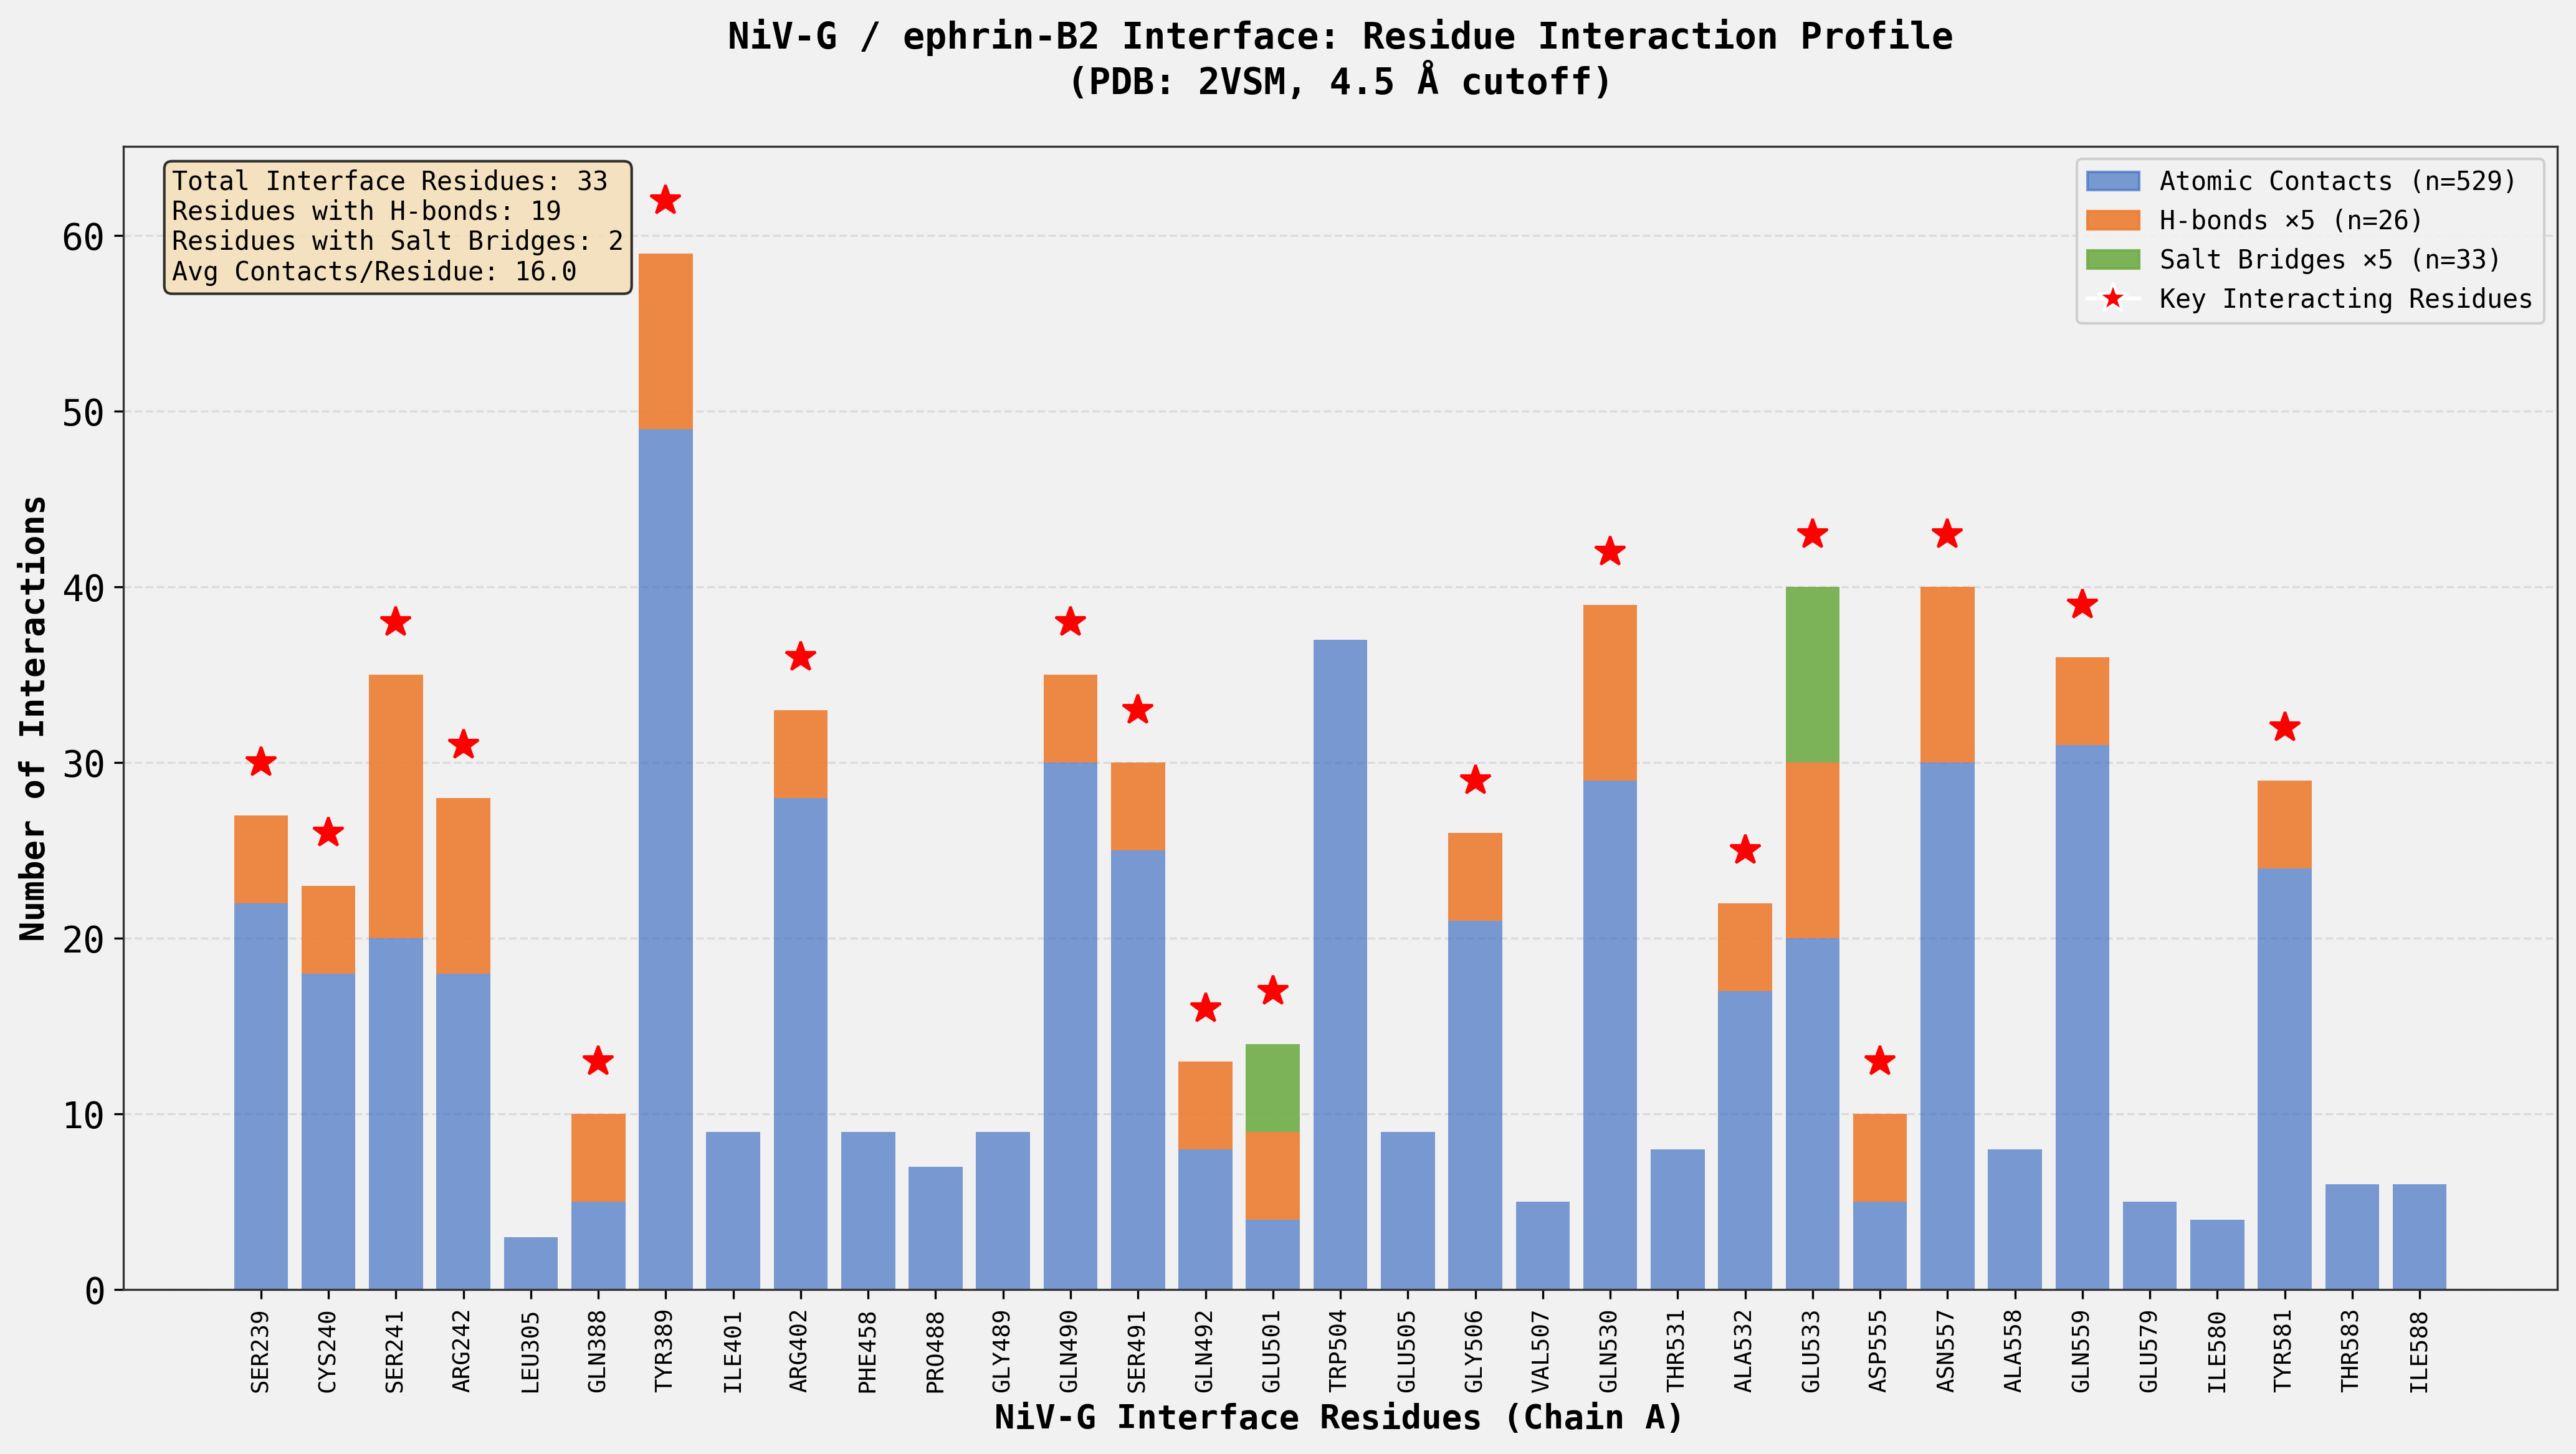


Visualization complete!


In [ ]:

# Step 8: Create a final visualization summarizing the key findings
# Create a comprehensive figure showing interface residues and their interaction profiles

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Set up the figure
fig, ax = plt.subplots(figsize=(14, 8))

# Prepare data for visualization
residue_numbers = interface_df['residue_number'].values
residue_labels = interface_df['residue_label'].values
contacts = interface_df['num_atomic_contacts'].values
hbonds = interface_df['num_hydrogen_bonds'].values
salt_bridges = interface_df['num_salt_bridges'].values

# Create x-axis positions
x_pos = np.arange(len(residue_numbers))

# Create stacked bar chart
bar_width = 0.8
bars1 = ax.bar(x_pos, contacts, bar_width, label='Atomic Contacts', color='#4472C4', alpha=0.7)
bars2 = ax.bar(x_pos, hbonds * 5, bar_width, bottom=contacts, label='H-bonds (×5)', color='#ED7D31', alpha=0.9)
bars3 = ax.bar(x_pos, salt_bridges * 5, bar_width, bottom=contacts + hbonds * 5, 
               label='Salt Bridges (×5)', color='#70AD47', alpha=0.9)

# Highlight high-interaction residues (those with H-bonds or salt bridges)
high_interaction_mask = (hbonds > 0) | (salt_bridges > 0)
for i, (has_interaction, label) in enumerate(zip(high_interaction_mask, residue_labels)):
    if has_interaction:
        # Add a marker for residues with specific interactions
        total_height = contacts[i] + hbonds[i] * 5 + salt_bridges[i] * 5
        ax.plot(i, total_height + 3, 'r*', markersize=12)

# Customize the plot
ax.set_xlabel('NiV-G Interface Residues (Chain A)', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Interactions', fontsize=13, fontweight='bold')
ax.set_title('NiV-G / ephrin-B2 Interface: Residue Interaction Profile\n(PDB: 2VSM, 4.5 Å cutoff)', 
             fontsize=14, fontweight='bold', pad=20)

# Set x-axis ticks and labels
ax.set_xticks(x_pos)
ax.set_xticklabels(residue_labels, rotation=90, ha='center', fontsize=9)

# Add grid for readability
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Create legend
legend_elements = [
    mpatches.Patch(color='#4472C4', alpha=0.7, label=f'Atomic Contacts (n={len(interface_contacts)})'),
    mpatches.Patch(color='#ED7D31', alpha=0.9, label=f'H-bonds ×5 (n={len(hydrogen_bonds)})'),
    mpatches.Patch(color='#70AD47', alpha=0.9, label=f'Salt Bridges ×5 (n={len(salt_bridges)})'),
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='r', 
               markersize=12, label='Key Interacting Residues')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10, framealpha=0.9)

# Add summary text box
textstr = f'Total Interface Residues: {len(interface_residues_sorted)}\n'
textstr += f'Residues with H-bonds: {len(hbond_counter)}\n'
textstr += f'Residues with Salt Bridges: {len(sb_counter)}\n'
textstr += f'Avg Contacts/Residue: {len(interface_contacts) / len(interface_residues_sorted):.1f}'

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

# Adjust layout
plt.tight_layout()
plt.savefig('niv_g_interface_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Figure saved to: niv_g_interface_analysis.png")
plt.show()

print("\nVisualization complete!")
